## PSO compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController
from utils.plot import *

Setting some global parameters

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'

ACC_MULTIPLIER = 4
CR_MULTIPLIER = 1

NUM_ITERATIONS = 1
NUM_PARTICLES = 20

SAVE_PSO_FILE = './results/test_PSO_save.csv'
SAVE_EVERY = 1

RANGE_OPTIMIZATION = True

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
particle_representation_ranges = [range(1, 21) for _ in range(5)]
particle_max_velocity = [2.5 for _ in range(5)]

share_order = [0, 1, 2, 3, 4]
retrain_amount = [0, 0, 0, 0, 0]

def fitness_fc(particle):
    # reset the net
    get_trained(model, NET_PATH, train_settings)
    for layer in ws_controller.model_layers:
        layer.weight.requires_grad = True
    
    # share weigts by particle

    particle.data = ws_controller.share(particle.representation, share_order, retrain_amount)

    if particle.data['accuracy'] <= 0.95:
        #return ACC_MULTIPLIER * math.log(1/(1 - particle.data['accuracy']))
        return particle.data['accuracy']

    #return ACC_MULTIPLIER * particle.data['accuracy'] + CR_MULTIPLIER * math.log(particle.data['compression'])
    #return math.log(1/(1 - particle.data['accuracy'])) * math.log(particle.data['compression'])
    return 1 / math.sqrt(pow(1 - ((particle.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (particle.data['compression']/14), 2))

In [6]:
data = {
    'time': [],
    'fitness': [],
    'position': [],
    'representation': [],
    'velocity': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'time' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['fitness'].append(particle.current_fit)
        new_data['position'].append(particle.position)
        new_data['representation'].append(particle.representation)
        new_data['velocity'].append(particle.velocity)
        new_data['accuracy'].append(particle.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - particle.data['accuracy'])
        new_data['compression'].append(particle.data['compression'])
        new_data['share_t'].append(particle.data['times']['share'])
        new_data['train_t'].append(particle.data['times']['train'])
        new_data['acc_t'].append(particle.data['times']['test'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_PSO_FILE), exist_ok=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

Setting ranges with optimization

In [7]:
particle_repr_ranges = [range(1, 21) for _ in range(5)]

lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    particle_repr_ranges = ws_controller.get_optimized_layer_ranges(particle_repr_ranges, lam_test_inp, 0.97, savefile='./results/lenet-layer-perf.csv')

particle_repr_ranges

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

Running the search

In [8]:
pso = PSOController(NUM_PARTICLES, particle_repr_ranges, particle_max_velocity, fitness_fc, 0.6)

if pso_data.size != 0:
    pso.load_from_pd(pso_data)

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Time 0/1 (20) best fitness 4.072225093841553
Time 1/1 (21) best fitness 4.072225093841553


[2, 6, 9, 14, 4]

In [9]:
pso_data

,time,fitness,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,1.689468,"[0.48705104785490483, 2.215792390795893, 5.315...","[16, 17, 20, 19, 14]","[-0.07158809749493444, -0.2473895748715713, -0...",0.9856,-0.0010,5.962336,0.944295,0.0,3.415709
1,0,2.550231,"[0.10506258222266507, 2.173855749528714, 6.570...","[4, 12, 5, 14, 8]","[-0.3091696847147869, 0.021953049199235422, 1....",0.9790,0.0056,9.363926,0.393168,0.0,3.356598
2,0,2.411282,"[0.3782829920157463, 2.396956614668304, 5.1440...","[7, 11, 4, 16, 9]","[-0.20696450810963457, 0.11397413797197263, -0...",0.9772,0.0074,9.150131,0.418104,0.0,3.473027
3,0,2.086391,"[0.3249619683450692, 2.5087020229011063, 5.923...","[9, 7, 14, 15, 15]","[0.14008735840368733, 0.2542965571113335, 1.00...",0.9844,0.0002,7.655218,0.687930,0.0,3.434410
4,0,2.400351,"[0.3231396639711172, 2.138681334456269, 6.3962...","[12, 18, 10, 4, 8]","[-0.18122640200853707, 0.028082169736885904, 1...",0.9806,0.0040,8.838490,0.526406,0.0,3.339850
...,...,...,...,...,...,...,...,...,...,...,...
435,21,3.896293,"[0.4806121713942542, 2.2533055884204276, 4.648...","[2, 6, 8, 14, 4]","[0.036170634538342204, -0.09685605076869454, -...",0.9750,0.0096,13.187112,0.516554,0.0,3.413884
436,21,3.781078,"[0.5547501614849062, 2.115191722427242, 4.7081...","[2, 6, 8, 15, 4]","[0.4057130761120116, -0.04510850401064511, -0....",0.9742,0.0104,13.185719,0.554315,0.0,3.438506
437,21,3.896293,"[0.5417811117450846, 2.235778589807076, 4.9717...","[2, 6, 8, 14, 4]","[-0.008214575720585537, -0.1502473576544341, 0...",0.9750,0.0096,13.187112,0.518092,0.0,3.378943
438,21,3.837352,"[0.5636932514138256, 2.084663990754806, 4.1139...","[2, 6, 8, 16, 4]","[0.0236955700539367, -0.01171416826292973, -0....",0.9746,0.0100,13.184329,0.550472,0.0,3.408816


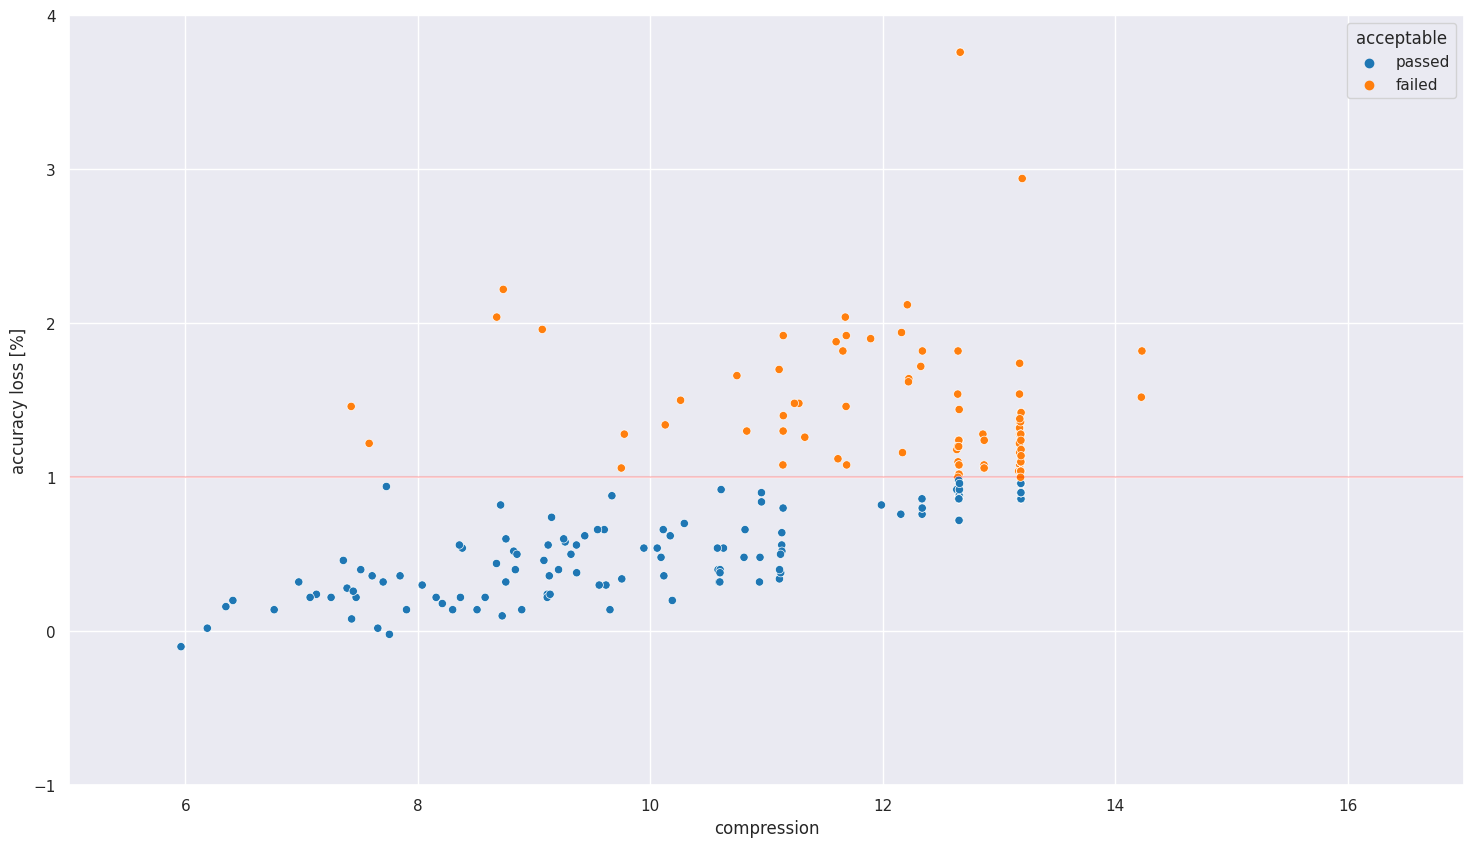

In [10]:
plot_alcr(pso_data)